# Proyek Prediksii Harga Rumah: [Daftar harga rumah di kawasan Tebet dan Jaksel]
- **Nama:** Ulfa Stevi Juliana
- **Email:** steviulpa@Gmail.coom
- **ID Dicoding:** MC189D5X2331


#Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

Pada tahap ini, dataset akan disiapkan sehingga siap untuk masuk ketahap permodelan

##Data understanding

Data loading

Pada tahap ini saya memuat dataset review hotel dengan format EXCEL. Dataset dapat diunduh pada link ini [Kaggle-Daftar harga rumah di kawasan Tebet dan Jaksel](https://www.kaggle.com/code/sateasinpedas/house-prediction-in-tebet-linear-regression/input).

In [2]:
df = pd.read_excel('DATA RUMAH.xlsx')
df.head()

,NO,NAMA RUMAH,HARGA,LB,LT,KT,KM,GRS
0,1,"Rumah Murah Hook Tebet Timur, Tebet, Jakarta S...",3800000000,220,220,3,3,0
1,2,"Rumah Modern di Tebet dekat Stasiun, Tebet, Ja...",4600000000,180,137,4,3,2
2,3,"Rumah Mewah 2 Lantai Hanya 3 Menit Ke Tebet, T...",3000000000,267,250,4,4,4
3,4,"Rumah Baru Tebet, Tebet, Jakarta Selatan",430000000,40,25,2,2,0
4,5,"Rumah Bagus Tebet komp Gudang Peluru lt 350m, ...",9000000000,400,355,6,5,3


In [3]:
df.info()
print("Shape of data:")
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   NO          1010 non-null   int64 
 1   NAMA RUMAH  1010 non-null   object
 2   HARGA       1010 non-null   int64 
 3   LB          1010 non-null   int64 
 4   LT          1010 non-null   int64 
 5   KT          1010 non-null   int64 
 6   KM          1010 non-null   int64 
 7   GRS         1010 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 63.3+ KB
Shape of data:
(1010, 8)


Insight :
Dataset harga rumah tebet terdiri dari 8 kolom dengan jumlah data 1100 data. Kolom tersebut terdiri dari :

* NO : nomor data.
* NAMA RUMAH : title rumah.
* HARGA : harga dari rumah.
* LB : jumlah luas bangunan.
* LT : jumlah luas tanah.
* KT : jumlah kamar tidur.
* KM : jumlah kamar mandi.
* GRS : jumlah kapasitas mobil dalam garasi.

insight : dataset memiliki 1010 baris data dengan jumlah kolom sebanyak delapan

#Data preparation

Pengecekan data duplikat

In [4]:
print("Jumlah data duplicated:", df.duplicated().sum(), end="")
df.isna().sum()

Jumlah data duplicated: 0

,0
NO,0
NAMA RUMAH,0
HARGA,0
LB,0
LT,0
KT,0
KM,0
GRS,0


Insight : tidak terdapat data duplikat

Melakukan pengecekan missing values pada semua fitur

In [5]:
df.isnull().sum()

,0
NO,0
NAMA RUMAH,0
HARGA,0
LB,0
LT,0
KT,0
KM,0
GRS,0


Insight : dapat dilihat bahwa tidak terdapat missing values

Mengubah nama variabel agar menggunakan huruf kecil saja

In [6]:
df = df.rename(columns={
    'NO': 'nomor',
    'NAMA RUMAH': 'nama_rumah',
    'HARGA': 'harga',
    'LB': 'lb',
    'LT': 'lt',
    'KT': 'kt',
    'KM': 'km',
    'GRS': 'grs'
})

Mengganti satuan harga agar lebih readable & dan menghapus kolom nomor karena tidak diperlukan

In [7]:
df['harga'] = (df['harga']/1000000).astype(int)
df.drop(columns=['nomor'], inplace=True)
df.head()

,nama_rumah,harga,lb,lt,kt,km,grs
0,"Rumah Murah Hook Tebet Timur, Tebet, Jakarta S...",3800,220,220,3,3,0
1,"Rumah Modern di Tebet dekat Stasiun, Tebet, Ja...",4600,180,137,4,3,2
2,"Rumah Mewah 2 Lantai Hanya 3 Menit Ke Tebet, T...",3000,267,250,4,4,4
3,"Rumah Baru Tebet, Tebet, Jakarta Selatan",430,40,25,2,2,0
4,"Rumah Bagus Tebet komp Gudang Peluru lt 350m, ...",9000,400,355,6,5,3


Memebuat label baru "Klasifikasi Harga"

In [8]:
q1 = df['harga'].quantile(0.25)
median = df['harga'].median()
q3 = df['harga'].quantile(0.75)

def classification_harga(harga):
    if harga <= q1:
        return 'Murah'
    elif harga <= median:
        return 'Menengah'
    else:
        return 'Mahal'

# Menambahkan kolom baru 'Klasifikasi Harga'
df['tingkat_harga'] = df['harga'].apply(classification_harga)

# Menampilkan DataFrame dengan kolom baru
df.head()

,nama_rumah,harga,lb,lt,kt,km,grs,tingkat_harga
0,"Rumah Murah Hook Tebet Timur, Tebet, Jakarta S...",3800,220,220,3,3,0,Menengah
1,"Rumah Modern di Tebet dekat Stasiun, Tebet, Ja...",4600,180,137,4,3,2,Menengah
2,"Rumah Mewah 2 Lantai Hanya 3 Menit Ke Tebet, T...",3000,267,250,4,4,4,Murah
3,"Rumah Baru Tebet, Tebet, Jakarta Selatan",430,40,25,2,2,0,Murah
4,"Rumah Bagus Tebet komp Gudang Peluru lt 350m, ...",9000,400,355,6,5,3,Mahal


In [9]:
df.describe()

,harga,lb,lt,kt,km,grs
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000
mean,7628.982178,276.539604,237.432673,4.668317,3.607921,1.920792
std,7340.945285,177.864557,179.957604,1.572776,1.420066,1.510998
min,430.000000,40.000000,25.000000,2.000000,1.000000,0.000000
25%,3262.500000,150.000000,130.000000,4.000000,3.000000,1.000000
50%,5000.000000,216.500000,165.000000,4.000000,3.000000,2.000000
75%,9000.000000,350.000000,290.000000,5.000000,4.000000,2.000000
max,65000.000000,1126.000000,1400.000000,10.000000,10.000000,10.000000


Visualiasasi data

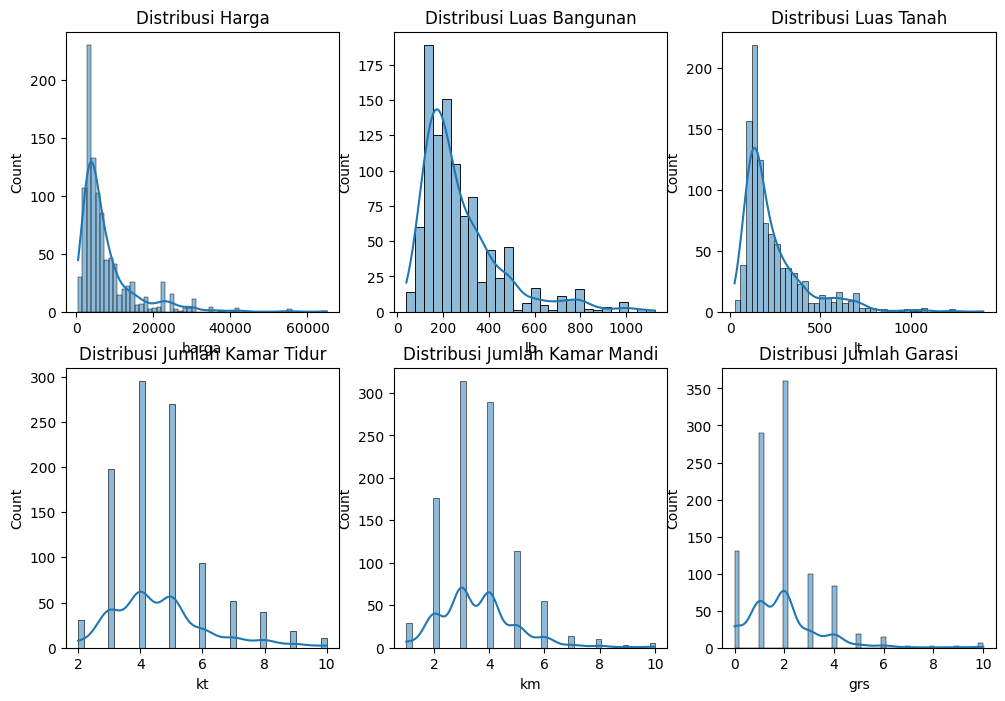

In [10]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
sns.histplot(df['harga'], kde=True)
plt.title('Distribusi Harga')

plt.subplot(2, 3, 2)
sns.histplot(df['lb'], kde=True)
plt.title('Distribusi Luas Bangunan')

plt.subplot(2, 3, 3)
sns.histplot(df['lt'], kde=True)
plt.title('Distribusi Luas Tanah')

plt.subplot(2, 3, 4)
sns.histplot(df['kt'], kde=True)
plt.title('Distribusi Jumlah Kamar Tidur')

plt.subplot(2, 3, 5)
sns.histplot(df['km'], kde=True)
plt.title('Distribusi Jumlah Kamar Mandi')

plt.subplot(2, 3, 6)
sns.histplot(df['grs'], kde=True)
plt.title('Distribusi Jumlah Garasi')
plt.show()

Insight :

Distribusi harga, luas bangunan (lb), dan luas tanah (lt) terlihat positively skewed, menunjukkan mayoritas data berada di kisaran rendah dengan sedikit data berharga/luas sangat tinggi.

Jumlah kamar tidur (kt), kamar mandi (km), dan garasi (grs) menunjukkan distribusi diskrit dengan puncak pada angka 3–5, yang merupakan jumlah umum pada rumah tinggal.

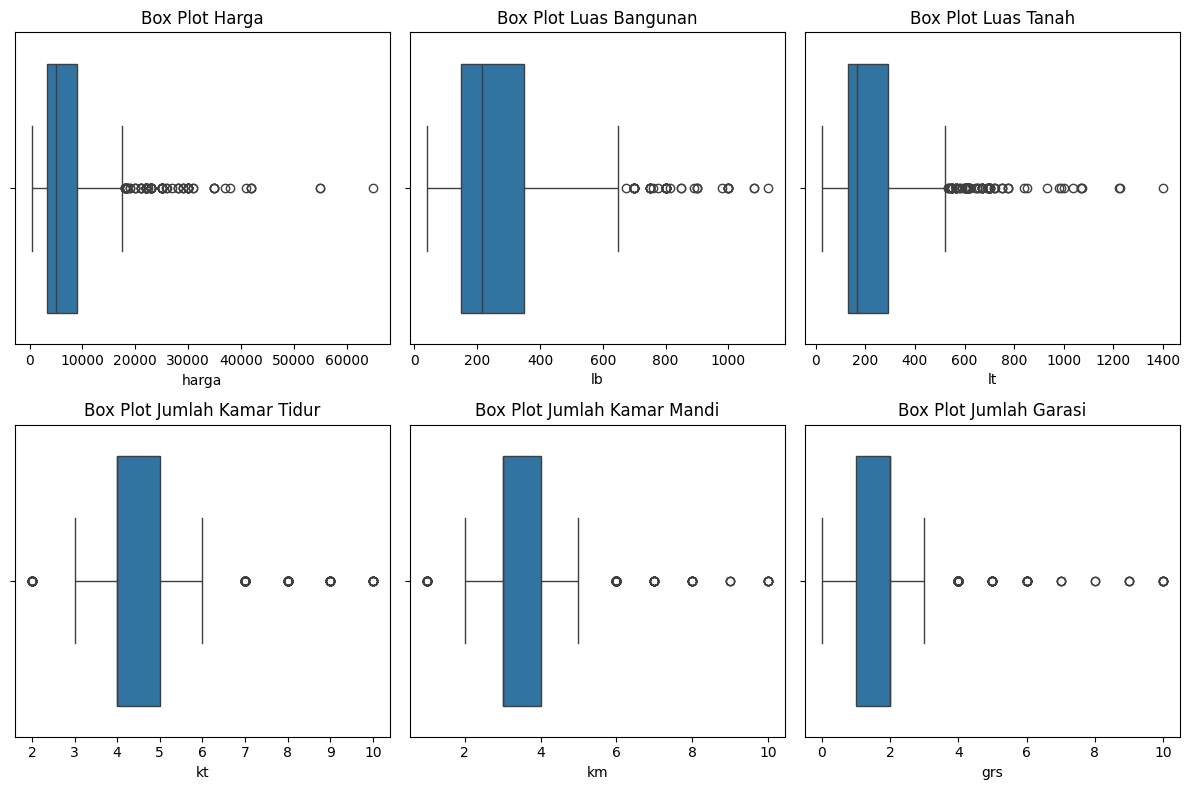

In [11]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
sns.boxplot(x=df['harga'])
plt.title('Box Plot Harga')

plt.subplot(2, 3, 2)
sns.boxplot(x=df['lb'])
plt.title('Box Plot Luas Bangunan')

plt.subplot(2, 3, 3)
sns.boxplot(x=df['lt'])
plt.title('Box Plot Luas Tanah')

plt.subplot(2, 3, 4)
sns.boxplot(x=df['kt'])
plt.title('Box Plot Jumlah Kamar Tidur')

plt.subplot(2, 3, 5)
sns.boxplot(x=df['km'])
plt.title('Box Plot Jumlah Kamar Mandi')

plt.subplot(2, 3, 6)
sns.boxplot(x=df['grs'])
plt.title('Box Plot Jumlah Garasi')

plt.tight_layout()
plt.show()

Insight :

Hampir semua fitur memiliki outlier, terutama harga, lt, dan lb. Outlier ini kemungkinan merepresentasikan rumah-rumah dengan nilai sangat tinggi atau properti mewah.

Meskipun terdapat outlier, persebaran mayoritas data tetap terkonsentrasi di rentang tengah, menunjukkan distribusi dominan di kelas menengah pasar properti.

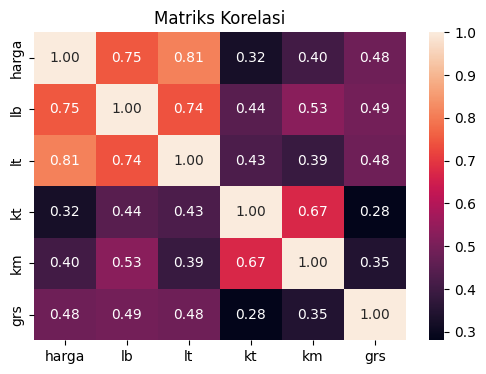

In [12]:
df_corr = df.drop(['tingkat_harga','nama_rumah'], axis=1)

correlation_all = df_corr.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_all, annot=True, cmap='rocket', fmt=".2f")
plt.title('Matriks Korelasi')
plt.show()

Insight :
Terdapat korelasi yang kuat antara harga dengan luas tanah (lt) (0.81) dan luas bangunan (lb) (0.75), yang artinya semakin besar luas tanah/bangunan, maka harga rumah cenderung semakin tinggi.

Korelasi harga terhadap jumlah kamar tidur, kamar mandi, dan garasi relatif lebih lemah, namun tetap memberikan kontribusi.

Penanganan Outlier
Outlier pada fitur seperti harga, luas bangunan, dan luas tanah dibiarkan karena:

* Variasi data penting dalam regresi – Model regresi membutuhkan keragaman data untuk menangkap pola yang kompleks.

* Outlier mencerminkan kondisi nyata – Properti unik atau mewah bisa menjadi bagian valid dari data.

* Distribusi miring (skewed) umum dalam data properti – Tidak selalu menandakan kesalahan.

* Korelasi tetap kuat – Outlier tidak mengganggu hubungan antar variabel utama.

Dengan demikian, outlier tetap dipertahankan agar model mampu belajar dari seluruh cakupan data.

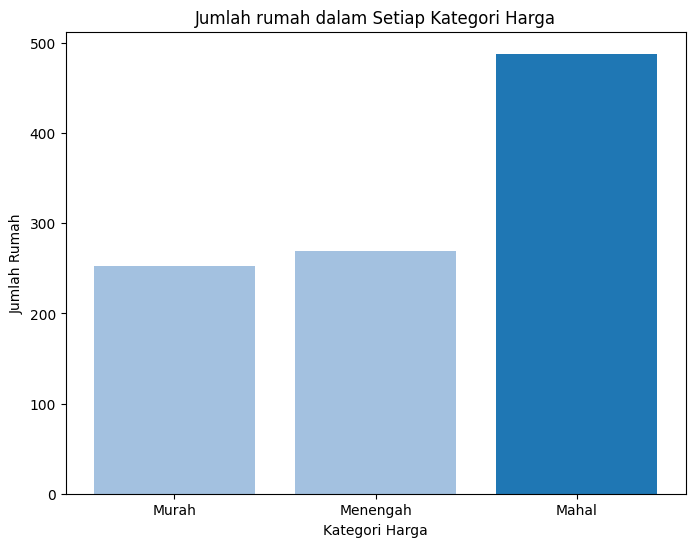

In [13]:
counts = df['tingkat_harga'].value_counts().reindex(['Murah', 'Menengah', 'Mahal'])

plt.figure(figsize=(8, 6))

base_light_color = '#a3c1e0'
dark_color = '#1f77b4'

colors = [base_light_color] * len(counts)

max_index = counts.argmax()

colors[max_index] = dark_color

plt.bar(counts.index, counts.values, color=colors)

plt.title('Jumlah rumah dalam Setiap Kategori Harga')
plt.xlabel('Kategori Harga')
plt.ylabel('Jumlah Rumah')
plt.show()

Insight : Dapat dilihat data terbanyak adalah rumah dengan harga mahal. Kemudian disusul oleh kategori harga menengah dan urutan terakhir kategori harga rumah yang murah

#Data Spliting 70/30

* X_train: ukuran data input untuk pelatihan

* X_test: ukuran data input untuk pengujian

* y_train: ukuran label pelatihan

* y_test: ukuran label pengujian



In [14]:
X = df[['lb','lt','kt','km','grs']].values #Feature
y = df['harga'].values #Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

#Model Training & Evaluation

1. Linear Regression
Model ini menggunakan pendekatan linier untuk menemukan hubungan antara fitur dan target (harga). Tidak memiliki parameter khusus dalam implementasi dasar. Cocok untuk data yang memiliki hubungan linear.

In [15]:
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

# Menghitung MAE, MSE, dan R2 Score untuk data pelatihan
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Menghitung MAE, MSE, dan R2 Score untuk data pengujian
mae_test = mean_absolute_error(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

# Menampilkan hasil evaluasi
print("Evaluasi Model pada Data Pelatihan:")
print(f'MAE: {mae_train}')
print(f'MSE: {mse_train}')
print(f'R2 Score: {r2_train}')
print("\nEvaluasi Model pada Data Pengujian:")
print(f'MAE: {mae_test}')
print(f'MSE: {mse_test}')
print(f'R2 Score: {r2_test}')

Evaluasi Model pada Data Pelatihan:
MAE: 2125.80658245656
MSE: 16846700.216882665
R2 Score: 0.7000572962795143

Evaluasi Model pada Data Pengujian:
MAE: 2064.454006457836
MSE: 11744519.540541148
R2 Score: 0.7572680284681441


2. Random Forest Regressor
Model ini adalah ensemble method berbasis pohon keputusan yang lebih fleksibel dan kuat terhadap data non-linear. Hyperparameter yang dituning:

* n_estimators: Jumlah pohon dalam hutan (dicoba: 50, 100, 200)

* max_depth: Kedalaman maksimum pohon (dicoba: None, 10, 20)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Hyperparameter tuning dengan GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Model terbaik hasil tuning
best_rf = grid_search.best_estimator_

# Prediksi pada data pelatihan dan pengujian
y_train_pred_rf = best_rf.predict(X_train)
y_test_pred_rf = best_rf.predict(X_test)

# Evaluasi pada data pelatihan
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

# Evaluasi pada data pengujian
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

# Tampilkan hasil evaluasi
print("Evaluasi Model Random Forest pada Data Pelatihan:")
print(f"MAE: {mae_train_rf}")
print(f"MSE: {mse_train_rf}")
print(f"R2 Score: {r2_train_rf}")

print("\nEvaluasi Model Random Forest pada Data Pengujian:")
print(f"MAE: {mae_test_rf}")
print(f"MSE: {mse_test_rf}")
print(f"R2 Score: {r2_test_rf}")


In [22]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 20, 'n_estimators': 200}


Insight : Ini adalah parameter terbaik sebagai Parameter Akhir Model

In [ ]:
import pandas as pd

compare_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R2 Train': [r2_train, r2_train_rf],
    'R2 Test': [r2_test, r2_test_rf],
    'MAE Test': [mae_test, mae_test_rf],
    'MSE Test': [mse_test, mse_test_rf]
})

print("\nPerbandingan Kinerja Model:")
print(compare_df)


Dari hasil evaluasi, model Random Forest menunjukkan performa lebih baik dibanding Linear Regression, terutama pada data pengujian (nilai R² lebih tinggi dan error lebih rendah), sehingga dipilih sebagai model final untuk prediksi harga rumah.

In [ ]:
# Visualisasi
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Scatter plot
plt.scatter(y_train, y_train_pred, alpha=0.6, color='blue', label='Data Pelatihan')
plt.scatter(y_test, y_pred, alpha=0.6, color='green', label='Data Pengujian')

# Garis ideal (prediksi sempurna)
min_val = min(np.min(y_train), np.min(y_test))
max_val = max(np.max(y_train), np.max(y_test))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Prediksi Ideal')

# Label dan judul
plt.xlabel('Nilai Aktual')
plt.ylabel('Prediksi')
plt.title('Visualisasi Regresi Random Forest: Prediksi vs Nilai Aktual')
plt.legend()
plt.tight_layout()
plt.show()

Insight :
Model Random Forest menunjukkan performa prediksi yang cukup solid dan cocok digunakan untuk memprediksi harga rumah berdasarkan fitur yang tersedia.

#Model Testing

In [21]:
import ipywidgets as widgets
from IPython.display import display

# Fungsi prediksi menggunakan model Random Forest terbaik
def predict_house_price(lb, lt, kt, km, grs):
    # Buat array dari input
    input_data = [[lb, lt, kt, km, grs]]

    # Lakukan prediksi menggunakan model Random Forest
    predicted_price = best_rf.predict(input_data)

    # Tampilkan hasil prediksi
    print("💰 Prediksi harga rumah Anda: IDR {:,.3f} juta".format(predicted_price[0]))

# Slider untuk masing-masing fitur
slider_lb = widgets.FloatSlider(value=100, min=50, max=500, step=10, description='LB (m²):')
slider_lt = widgets.FloatSlider(value=200, min=60, max=1000, step=10, description='LT (m²):')
slider_kt = widgets.IntSlider(value=3, min=1, max=10, step=1, description='Kamar Tidur:')
slider_km = widgets.IntSlider(value=2, min=1, max=10, step=1, description='Kamar Mandi:')
slider_grs = widgets.IntSlider(value=1, min=0, max=3, step=1, description='Garasi:')

# Tampilkan UI interaktif
ui = widgets.interactive(predict_house_price, lb=slider_lb, lt=slider_lt, kt=slider_kt, km=slider_km, grs=slider_grs)
display(ui)


interactive(children=(FloatSlider(value=100.0, description='LB (m²):', max=500.0, min=50.0, step=10.0), FloatS…